In [2]:
import os

base_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

print("Train folders:", os.listdir(base_path + "/train"))
print("Valid folders:", os.listdir(base_path + "/valid"))


Train folders: ['fake', 'real']
Valid folders: ['fake', 'real']


In [3]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
GPU name: Tesla T4


In [4]:
import os

base_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

print("Train folders:", os.listdir(base_path + "/train"))
print("Valid folders:", os.listdir(base_path + "/valid"))


Train folders: ['fake', 'real']
Valid folders: ['fake', 'real']


In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_data = datasets.ImageFolder(base_path + "/train", transform=transform)
val_data   = datasets.ImageFolder(base_path + "/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)

print("Classes:", train_data.classes)
print("Training images:", len(train_data))
print("Validation images:", len(val_data))


Classes: ['fake', 'real']
Training images: 100000
Validation images: 20000


In [7]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeepFakeCNN(nn.Module):
    def __init__(self):
        super(DeepFakeCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepFakeCNN().to(device)
print("Custom CNN ready!")


Custom CNN ready!


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
best_acc = 0

for epoch in range(5):  # you can change number of epochs
    model.train()
    running_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # 🔹 Validation Step
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Val Accuracy = {val_acc:.2f}%")

    # 🔹 Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_deepfake_model.pth")
        print("✅ Best model saved!")


Epoch 1: Loss = 0.4772, Val Accuracy = 86.65%
✅ Best model saved!
Epoch 2: Loss = 0.2338, Val Accuracy = 91.59%
✅ Best model saved!
Epoch 3: Loss = 0.1349, Val Accuracy = 94.53%
✅ Best model saved!
Epoch 4: Loss = 0.0895, Val Accuracy = 95.33%
✅ Best model saved!
Epoch 5: Loss = 0.0664, Val Accuracy = 95.22%


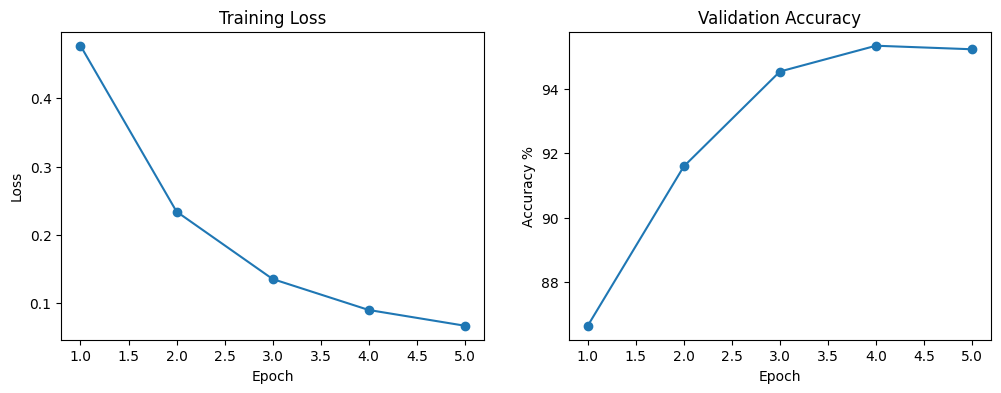

In [10]:
import matplotlib.pyplot as plt

epochs = [1,2,3,4,5]
losses = [0.4772, 0.2338, 0.1349, 0.0895, 0.0664]
accs = [86.65, 91.59, 94.53, 95.33, 95.22]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(epochs, accs, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")

plt.show()


In [11]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate model architecture
class DeepFakeCNN(nn.Module):
    def __init__(self):
        super(DeepFakeCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = DeepFakeCNN().to(device)
model.load_state_dict(torch.load("/kaggle/working/best_deepfake_model.pth", map_location=device))
model.eval()
print("Model loaded for prediction!")


Model loaded for prediction!


In [12]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)

    classes = ["FAKE", "REAL"]
    return classes[predicted.item()]


Testing REAL image:


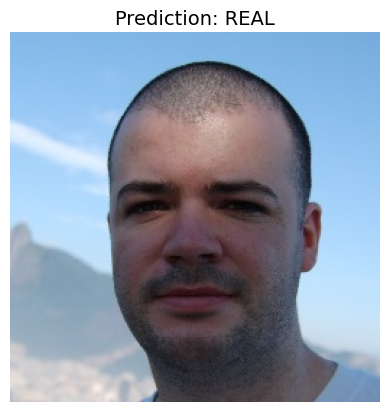

Testing FAKE image:


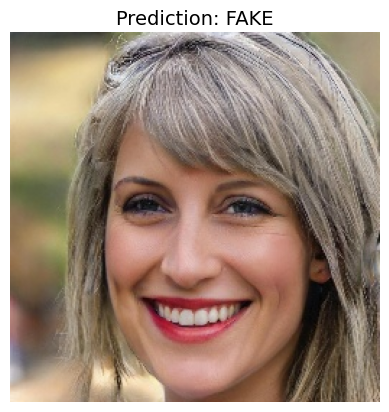

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

def show_prediction(image_path):
    # Load and predict
    prediction = predict_image(image_path)
    
    # Display image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Prediction: {prediction}", fontsize=14)
    plt.axis('off')
    plt.show()

# ---- Test on a REAL image ----
real_dir = base_path + "/valid/real"
real_img_path = os.path.join(real_dir, random.choice(os.listdir(real_dir)))

print("Testing REAL image:")
show_prediction(real_img_path)

# ---- Test on a FAKE image ----
fake_dir = base_path + "/valid/fake"
fake_img_path = os.path.join(fake_dir, random.choice(os.listdir(fake_dir)))

print("Testing FAKE image:")
show_prediction(fake_img_path)


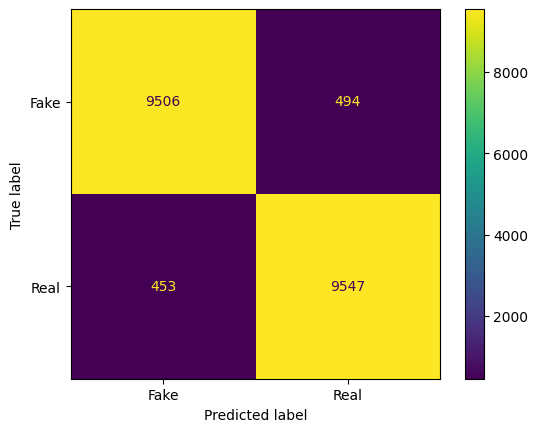

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot()
plt.show()
